In [16]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from matplotlib import transforms
import networkx as nx
from matplotlib.gridspec import GridSpec

from sklearn.decomposition import PCA


import os
import sys
from importlib import reload

# local imports 
import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
reload(pcu)
reload(binning)
reload(filters)

<module 'filters' from '/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/filters.py'>

In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
filetags = [f"run0{x}" for x in cellNums]

# filetags = [f"run0{x}" for x in range(1, 2)]

assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
rawCells = pcu.loadRawContactDirectory(dirpath, filetags)
print(f"{rawCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
rawCells.keys()=dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [4]:
reload(pcu)
reload(binning)
reload(filters)

filteredCells = filters.runAllFilters(rawCells,
                              assembly,
                              adjacent=True,
                              chromosome='NC_000068.8', 
                              verbose=True)  

print(f"{filteredCells.keys()=}")

------------------------------
runId='run01'
cf.shape=(5109, 64)
-- -- --
Total Reads 3539 (1.000)
Singletons 2552 (0.721)
Pairs 641 (0.181)
Multiway 346 (0.098)
-- -- --
Total Contacts 5109 (1.000)
cis Contacts 5109 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 5109 (1.000)
Direct Contacts 5109 (1.000)
Indirect Contacts 0 (0.000)

------------------------------
runId='run02'
cf.shape=(2501, 64)
-- -- --
Total Reads 1840 (1.000)
Singletons 1402 (0.762)
Pairs 300 (0.163)
Multiway 138 (0.075)
-- -- --
Total Contacts 2501 (1.000)
cis Contacts 2501 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 2501 (1.000)
Direct Contacts 2501 (1.000)
Indirect Contacts 0 (0.000)

------------------------------
runId='run04'
cf.shape=(2429, 64)
-- -- --
Total Reads 1739 (1.000)
Singletons 1289 (0.741)
Pairs 288 (0.166)
Multiway 162 (0.093)
-- -- --
Total Contacts 2429 (1.000)
cis Contacts 2429 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 2429 (1.000)
Direct Contacts 2429 (1

# make interaction networks

In [5]:
reload(pcu)
reload(binning)

chomosome = 2
chromLength = assembly.loc[assembly['Chromosome'] == str(chomosome), 'Total length'].values[0]

resolution = 1000000 # 1mb scale
chromBins = binning.getBins(chromLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

matrices = {}

for runId, data in filteredCells.items():
    print(f"{runId=}")
    
    chrom = binning.chromosomeBinData(data, 
                                     chromBins, 
                                     label1=label1, 
                                     label2=label2)
    
    A = pcu.getHic(chrom, chromBins, label1, label2)
    print(f"{A.shape=}")
    print(f"{np.max(A)=}")
    matrices[runId] = A
    
    print()
    
print(f"{matrices.keys()}")

runId='run01'
A.shape=(182, 182)
np.max(A)=2.0

runId='run02'
A.shape=(182, 182)
np.max(A)=2.0

runId='run04'
A.shape=(182, 182)
np.max(A)=2.0

runId='run05'
A.shape=(182, 182)
np.max(A)=2.0

runId='run06'
A.shape=(182, 182)
np.max(A)=2.0

runId='run07'
A.shape=(182, 182)
np.max(A)=2.0

dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [6]:
break

SyntaxError: 'break' outside loop (<ipython-input-6-6aaf1f276005>, line 1)

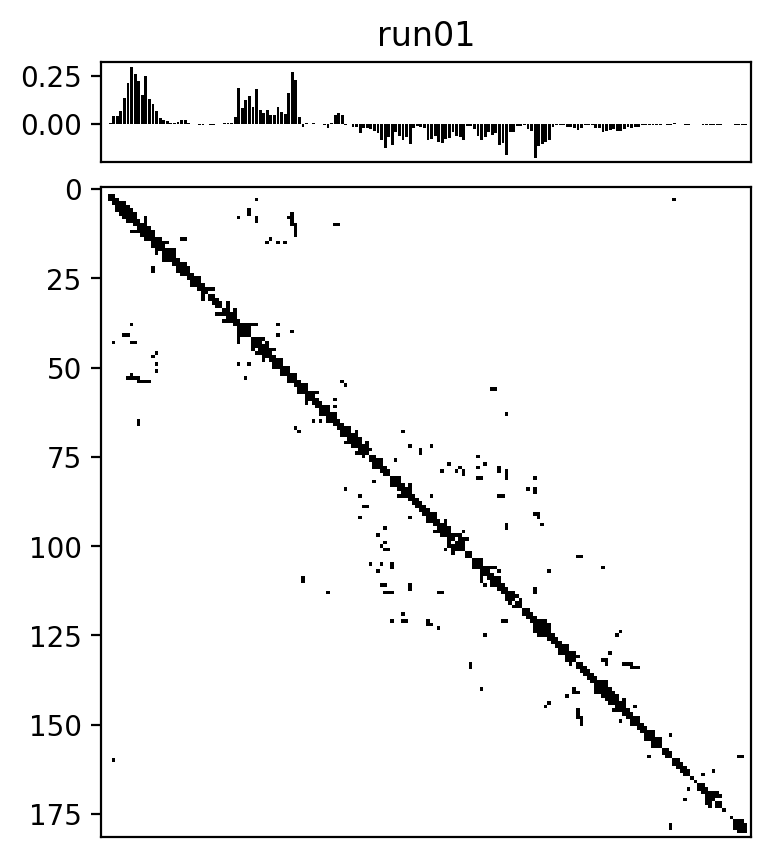

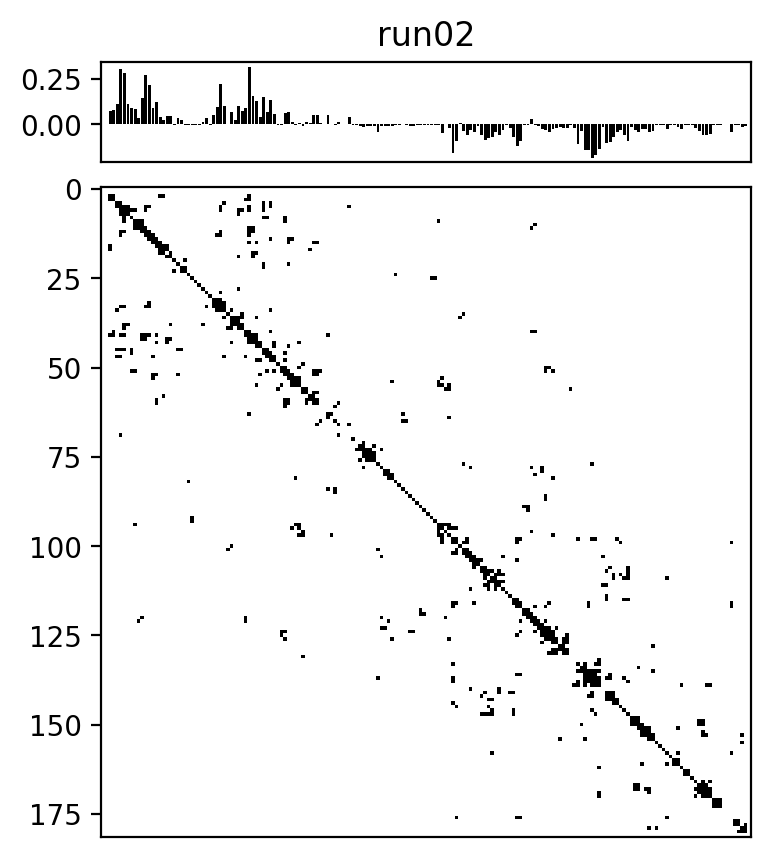

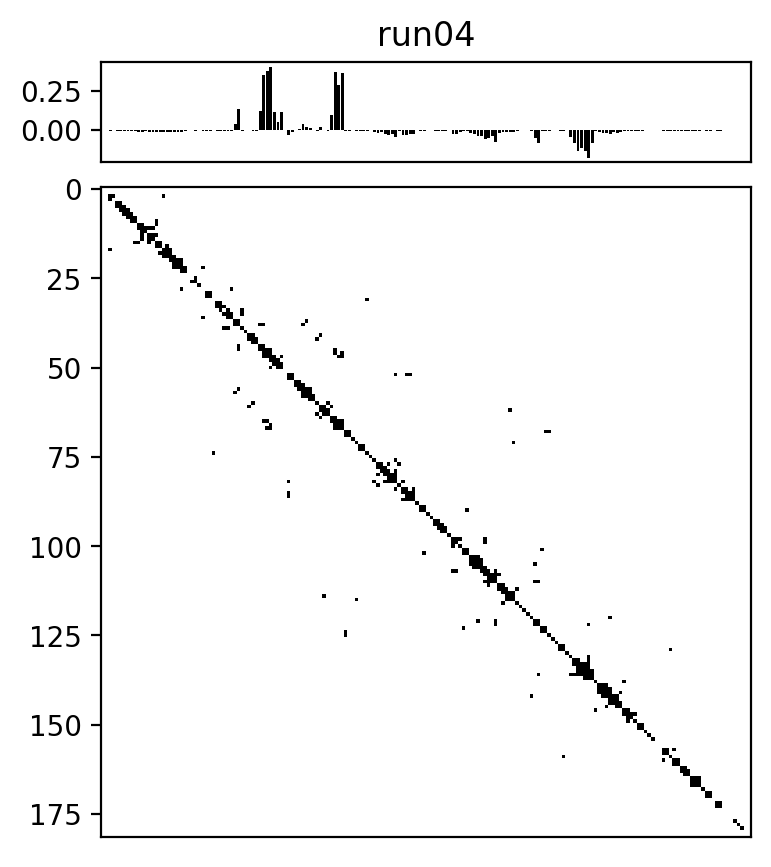

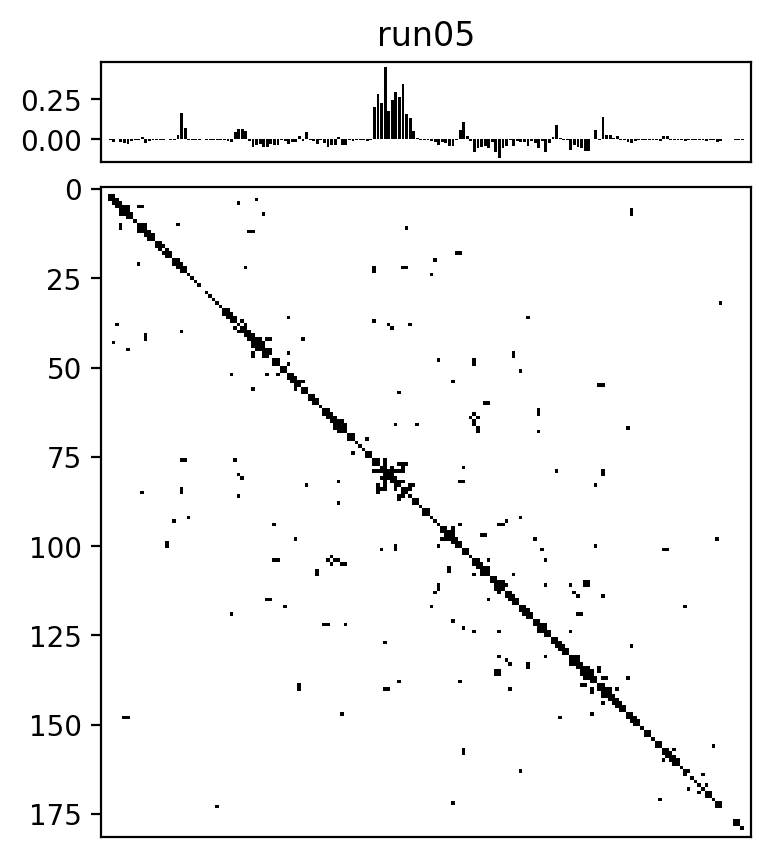

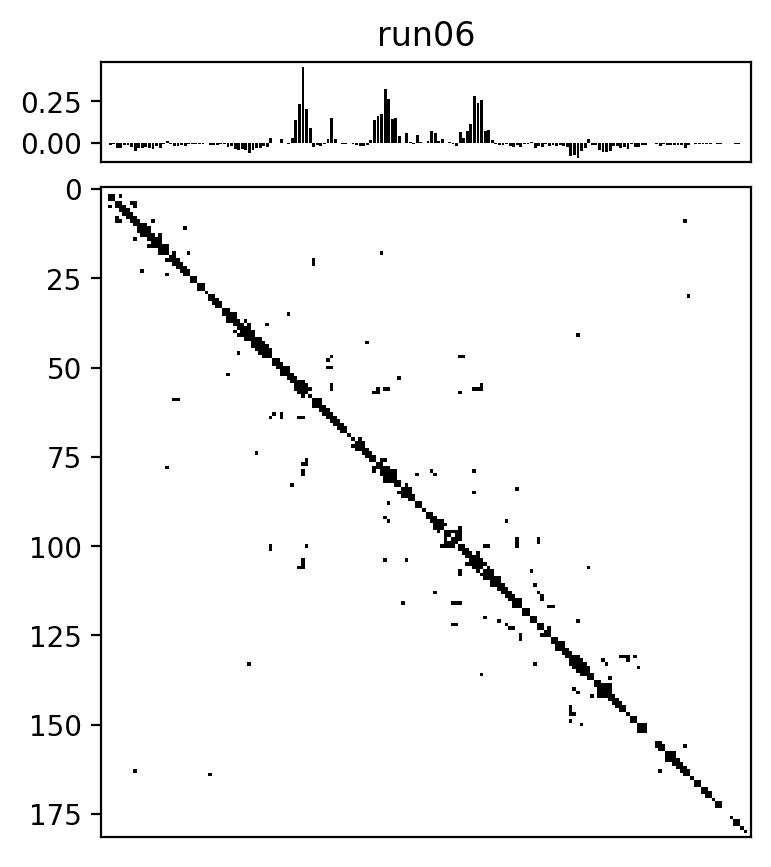

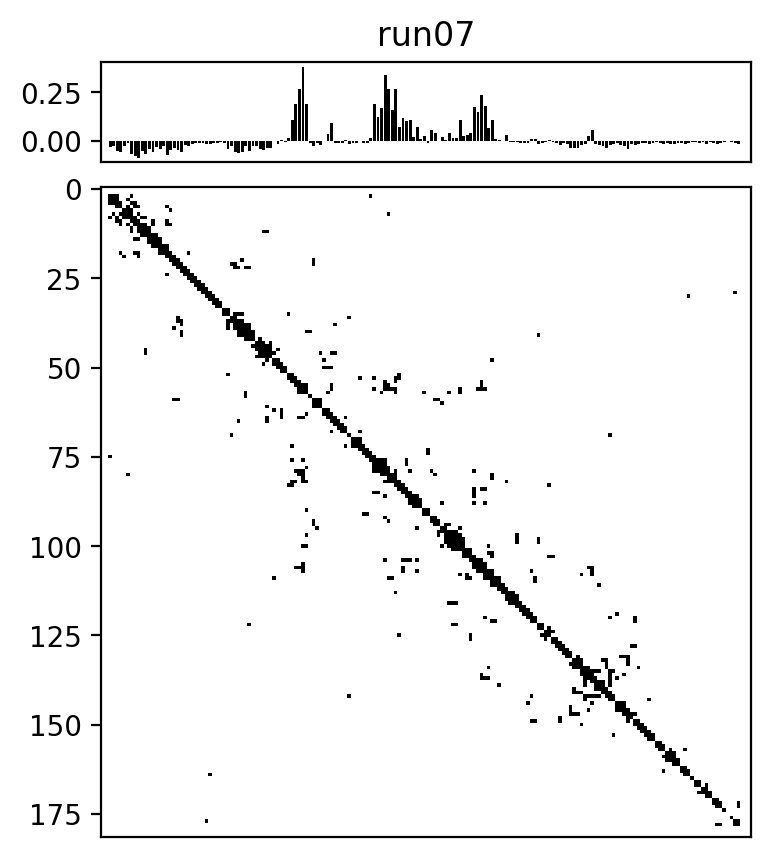

In [35]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 7

for runId, A in matrices.items():
    
    Abinary = np.where(A > 0, 1, 0)
    
    pca = PCA(n_components=1, svd_solver='full')
    pca.fit(A)
    
    pc1 = pca.components_[0, :]
    
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.025

    hicPlotSize = [left, bottom, width, height]
    pcPlotSize = [left, bottom + height + spacing, width, 0.1]
    
    # start with a square Figure
    fig = plt.figure(figsize=(5, 5))

    ax1 = fig.add_axes(hicPlotSize)
    ax1.imshow(Abinary, cmap='binary')
    
    ax2 = fig.add_axes(pcPlotSize, sharex=ax1)
    ax2.bar(list(range(len(pc1))), pc1, color='k')
    ax2.set_title(runId)
    ax2.set_xticks([])

    plt.show()


In [ ]:
# %matplotlib inline

# plt.rcParams['figure.dpi'] = 200
# # plt.rcParams['figure.figsize'] = 5, 7

# for runId, A in matrices.items():
    
#     # binary representation
#     Abinary = np.where(A > 0, 1, 0)
    
#     G = nx.from_numpy_array(A)
#     cent = nx.eigenvector_centrality(G, max_iter=1000)
    
#     left, width = 0.1, 0.65
#     bottom, height = 0.1, 0.65
#     spacing = 0.025

#     hicPlotSize = [left, bottom, width, height]
#     centralityPlotSize = [left, bottom + height + spacing, width, 0.1]
    
#     # start with a square Figure
#     fig = plt.figure(figsize=(5, 5))

#     ax1 = fig.add_axes(hicPlotSize)
#     ax1.imshow(Abinary, cmap='binary')
    
#     ax2 = fig.add_axes(centralityPlotSize, sharex=ax1)
#     ax2.bar(cent.keys(), cent.values(), color='k')
#     ax2.set_title(runId)
#     ax2.set_xticks([])

#     plt.show()

# Psuedobulk

[]

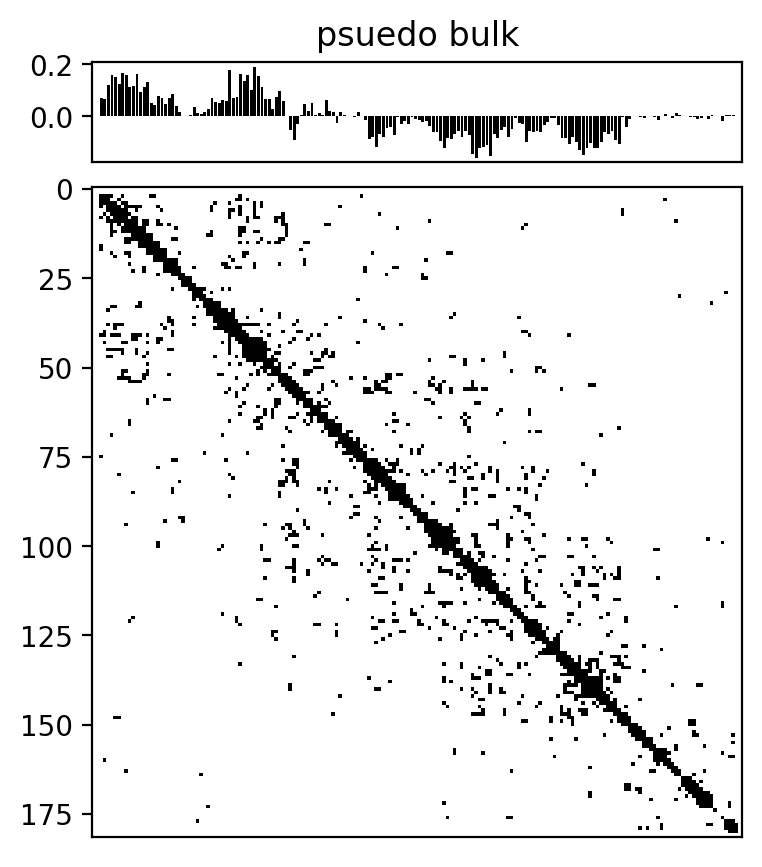

In [36]:
psuedoBulk = np.zeros((matrices['run01'].shape))

for runId, A in matrices.items():
    psuedoBulk = psuedoBulk + A
    

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

binaryBulk = np.where(psuedoBulk > 0, 1, 0)

# PCA
pca = PCA(n_components=1, svd_solver='full')
pca.fit(binaryBulk)

pc1 = pca.components_[0, :]


left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.025


hicPlotSize = [left, bottom, width, height]
pcPlotSize = [left, bottom + height + spacing, width, 0.1]

# start with a square Figure
fig = plt.figure()

ax1 = fig.add_axes(hicPlotSize)
ax1.imshow(binaryBulk, cmap='binary')


ax2 = fig.add_axes(pcPlotSize, sharex=ax1)
ax2.bar(list(range(len(pc1))), pc1, color='k')
ax2.set_title('psuedo bulk')
ax2.set_xticks([])

In [ ]:

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 5

# for runId, A in matrices.items():
    
#     plt.imshow(binaryBulk, 
#                cmap='binary', 
#                interpolation='none',
#                alpha=0.4)
    
#     binaryA = np.where(A > 0, 1, 0)
#     plt.imshow(binaryA, 
#                cmap='Reds', 
#                interpolation='none', 
#                alpha=0.6)
    
#     plt.title(runId)
#     plt.show()
    

# Centrality

In [ ]:
# centrality analysis


plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 10, 3

ef = pd.DataFrame(index=range(len(chromBins)))


for runId, A in matrices.items():
    G = nx.from_numpy_array(A)
    cent = nx.eigenvector_centrality(G, max_iter=1000)
    
    tmp = pd.Series(cent.values())
    tmp.name = runId
    ef = pd.concat([ef, tmp], axis=1)

    
ef.loc[:,'sum'] = ef.sum(numeric_only=True, axis=1)
    
print(f"{ef.shape=}")
ef.head()

In [ ]:

# for c in ef.columns:
#     if not c == 'sum':
#         plt.bar(ef.index, ef['sum'])
#         plt.bar(ef.index, ef[c])
#         plt.show()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

corrMat = ef[matrices.keys()].corr()

sns.heatmap(corrMat, 
            cmap='viridis',  
            center=0,
            annot=True, 
            fmt='.2g',
            linewidths=.5)

plt.title("Cell vs. Cell Correlations (Eigenvector Centrality)")

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 9, 9

corrMat = ef[matrices.keys()].T.corr()

sns.heatmap(corrMat, 
            cmap='Reds',
            alpha=0.7,
            center=0)

plt.title("Bin vs. Bin Correlations (Eigenvector Centrality)")

In [ ]:
# # edit distance between single cells

# Gsim = np.zeros((len(matrices), len(matrices)))

# for i, (runId1, A1) in enumerate(matrices.items()):
#     print(f"{runId1=}")
#     for j, (runId2, A2) in enumerate(matrices.items()):
#         print(f"{runId2=}")
        
#         G1 = nx.from_numpy_array(A1)
#         G2 = nx.from_numpy_array(A2)
        
#         measure = nx.graph_edit_distance(G1, G2)
#         Gsim[i, j] = measure
#         Gsim[j, i] = measure
        

# plt.matshow(Gsim)      
        
        

In [ ]:
for runId, A in matrices.items():
    
    # remove self-loops for cleaner graph
    A = A - np.diag(np.diag(A))
    
    G = nx.from_numpy_array(A)
    
    print("-------------------------")
    print(f"{runId=}")
    print(f"{nx.average_clustering(G)=:.3f}")
    print(f"{nx.density(G)=:.3f}")
    print(f"{nx.number_of_edges(G)=}")

In [ ]:
threshold = 0.5

imputedContacts = []

for runId, A in matrices.items():
    
    G = nx.from_numpy_array(A)    
    P = np.zeros(A.shape)
    
#     pLink = nx.preferential_attachment(G)   
    pLink = nx.common_neighbor_centrality(G, alpha=0.1)
    
    for i, j, p in pLink:
        P[i, j] = P[i, j] + p
        P[j, i] = P[j, i] + p
    
    # normalize the link scores
    P = P / P.max()
    
    # threshold based prediction
    P = np.where(P >= threshold, 1, 0)
    
    # impute new contacts
    imputedA = A + P
    imputedContacts.append(imputedA)
    
    fig, ax = plt.subplots(1, 3) 
    
    ax[0].matshow(A)
    ax[0].set_title('Original Contacts', y=1.1)
    
    ax[1].matshow(P)
    ax[1].set_title('Predicted Contacts', y=1.1)
    
    ax[2].matshow(imputedA)
    ax[2].set_title('Imputed Contacts', y=1.1)
    
    plt.suptitle(runId, y=0.7)




In [ ]:
imputedBulk = np.zeros((matrices['run01'].shape))

for imp in imputedContacts:
    imputedBulk += imp

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

plt.matshow(imputedBulk, cmap='plasma')
plt.title('imputed psuedo bulk')
plt.colorbar(fraction=0.046, pad=0.04)

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams['figure.facecolor'] = 'white'

componentThreshold = 3

def removeDisconnectedComponents(G, threhsold):
   # remove disconnected components
    for component in list(nx.connected_components(G)):
        if len(component) < threhsold:
            for node in component:
                G.remove_node(node)
    return G

                
cmap = 'Reds'

for runId, A in matrices.items():
    
    # remove self-loops for cleaner graph
    A = A - np.diag(np.diag(A))
    
    G = nx.from_numpy_array(A)
    
    G = removeDisconnectedComponents(G, componentThreshold)
    
    degrees = [val*20 for (node, val) in G.degree()]
    
    G.pos = nx.circular_layout(G)

    nx.draw_networkx_nodes(G, 
                           pos=G.pos,
                           node_size=50,
                           node_color = G.nodes,
                           edgecolors = 'k',
                           alpha=1,
                           cmap=cmap)
    
#     nx.draw_networkx_labels(G, 
#                         pos=G.pos,
#                         font_size=5
#                        )
    
    nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=1,
                       alpha=0.6)
    
    
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), 
                           norm=plt.Normalize(vmin = 0, vmax=1))
    sm._A = []
    cbar = plt.colorbar(sm, ticks=[0, 1], aspect=80, fraction=0.02, pad=0.012)
    cbar.ax.set_yticklabels(['Chr Start', 'Chr End'])
    cbar.set_label('Bin Position', rotation=270)
    
    
    
    break
    

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 15, 15
# plt.rcParams['figure.facecolor'] = 'white'

# cmap = 'viridis'

# for runId, A in matrices.items():
    
#     A = A - np.diag(np.diag(A))
    
#     print(f"{A.max()}")
    
#     G = nx.from_numpy_array(A)
    
#     G.pos = nx.circular_layout(G)
    
#     # draw the network - more control if you draw nodes and edges separately 
#     nx.draw_networkx_nodes(G,
#                            pos=G.pos,
#                            node_size=150,
#                            node_color = G.nodes,
#                            edgecolors = 'k',
#                            alpha=0.2,
#                            cmap=cmap
#                           )
    
#     nx.draw_networkx_labels(G, 
#                             pos=G.pos,
#                             font_size=5
#                            )
    
#     nx.draw_networkx_edges(G,
#                            pos=G.pos,
#                            width=1,
#                            alpha=0.5
#                           )
    

    
#     break